In [1]:
import numpy as np
import pandas as pd
#import numpy and pandas libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt

#import necessary libraries in Pytorch and matplotlib

In [3]:
dataset_folder = "../../dataset/"
oil_df = pd.read_csv(dataset_folder + 'oil.csv')
coin_df = pd.read_csv(dataset_folder + 'coin.csv')
microsoft_df = pd.read_csv(dataset_folder + 'microsoft.csv')
sp500_df = pd.read_csv(dataset_folder + 'sp500.csv')
artificial1_df = pd.read_csv(dataset_folder + 'Artificial_trend.csv')

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#we import MinMaxScaler function from sklearn to scale our dataset and also make a instance of that

In [5]:
def format_train_test (batch_size,data,percent,num_predicts):
    length_train = int(data.shape[0]*(1-percent))
    a1 = length_train//batch_size
    length_train = batch_size*a1
    train_data = data.iloc[:,1:2].values
    train_data = scaler.fit_transform(train_data)
    train_set = []
    train_label = []
    for i in range(length_train):
        train_set.append(train_data[i:i + num_predicts])
        train_label.append(train_data[i + num_predicts:i + 2*num_predicts])
    
    length_test = int(data.shape[0] - length_train - 4*num_predicts)
    a2 = length_test//batch_size
    length_test = int(batch_size*a2) 
    test = data.iloc[:,1:2].values
    test = scaler.fit_transform(test)
    test_data = test[length_train + 2*num_predicts:length_train + length_test + 4*num_predicts]
    test_set = []
    test_label = []
    for j in range(length_test):
        test_set.append(test_data[j:j + num_predicts])
        test_label.append(test_data[j + num_predicts:j + 2*num_predicts])
        
    
    train_set = np.reshape(np.array(train_set),(np.array(train_set).shape[0], np.array(train_set).shape[1], 1))
    train_label = np.reshape(np.array(train_label),(np.array(train_label).shape[0], np.array(train_label).shape[1]))
    test_set = np.reshape(np.array(test_set),(np.array(test_set).shape[0], np.array(test_set).shape[1], 1))
    test_label = np.reshape(np.array(test_label),(np.array(test_label).shape[0], np.array(test_label).shape[1]))
    
    return train_set, train_label, test_set, test_label, length_test
#Here is the function to make train set, test set, and label for each of them from the dataframe. We first want to see how many
#We want to find the percent of data used for train set. Then, we find length of train data so that it could divisible by batch 
#size. Then we scale the dataset and make train set and label for each by iterating through the dataset until and make them lag
#by number of predict steps we want until we have desired amount of data for train process. Then, we find the length for test
#set and we repeat the same process as forming train set and its label.

In [6]:
p = 30

In [7]:
train_set, train_label, test_set, test_label, length_test = format_train_test(64,coin_df,0.2,p)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [8]:
class LSTM_model(nn.Module):
    def __init__(self, out_size, in_size, hidden_size1, hidden_size2,batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.in_size = in_size
        self.out_size = out_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lstm1 = nn.LSTM(input_size=self.in_size,hidden_size=self.hidden_size1,num_layers=1,batch_first=True)
        self.lstm2 = nn.LSTM(input_size=self.hidden_size1,hidden_size=self.hidden_size2,num_layers=1,batch_first=True)
        self.last = nn.Linear(self.hidden_size2, self.out_size)
    def forward(self,x,old_state):
        s1,state1 = self.lstm1(x,old_state)
        s2,state2 = self.lstm2(s1,state1)
        return self.last(s2[:,-1]), state2
    def initial_s(self, num_predicts):
        return (torch.zeros(1,self.batch_size, self.hidden_size1),
                torch.zeros(1,self.batch_size, self.hidden_size1))
#Here we make a class of LSTM models. We use two lstm steps with 2 layers each and then the dense layer at the end to output prediction
#Here we also need to keep track of the state for LSTM layers. We also make initial states with 2 zeros tensors

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device
# we check for the availablibility of GPU to use for training

device(type='cuda', index=0)

In [10]:
model = LSTM_model(p,1,55,55,64)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#we make model, upload it to GPU, make CrossEntropy loss instance as long as the Adam optimizer with learning rate of 0.001

In [11]:
print(model) #print the model summary

LSTM_model(
  (lstm1): LSTM(1, 55, batch_first=True)
  (lstm2): LSTM(55, 55, batch_first=True)
  (last): Linear(in_features=55, out_features=30, bias=True)
)


In [12]:
def train_test(model,train_tensor,test_tensor,criterion,optimizer,device,num_predicts,iterations):
    tr = []
    te = []
    predict = []
    for layer in model.children():
        layer.reset_parameters()
    for i in range(iterations):
        h0, c0 = model.initial_s(num_predicts)
        h, c = h0.to(device), c0.to(device)
        for (x,y) in train_tensor:
            x, y = x.to(device), y.to(device)
            y_hat, (h, c) = model(x.float(), (h, c))
            loss = criterion(y_hat, y.float())
            optimizer.zero_grad()
            h = h.detach()
            c = c.detach()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            h01, c01 = model.initial_s(num_predicts)
            h1, c1 = h01.to(device), c01.to(device)
            lost_val = 0
            for (x1, y1) in test_tensor:
                x1, y1 = x1.to(device), y1.to(device)
                y_hat1, (h1, c1) = model(x1.float(),(h1,c1))
                loss1 = criterion(y_hat1, y1.float())
                lost_val += loss1.item()
                h1 = h1.detach()
                c1 = c1.detach()
                if i == (iterations-1):
                    predict.append(y_hat1)
                
            lost_val /= len(x1)
            tr.append(loss.item())
            te.append(lost_val)
            print(f"Iteration {i}\n********************")
            print('The loss for train is: ',loss.item())
            print('The loss for test is: ',lost_val)
            for j in range(len(predict)):
                predict[j] = predict[j].cpu().numpy()
    return i, tr, te, predict
#Here we create function to do the training and validation process. We iterate through number of epochs, make initial state for model
#and iterate through each data batch to do prediction, compute the loss and do backward propagation to improve the parameters. In
#the same epoch, I also apply the model to make prediction on test dataset to keep track of model performace more closely. I also
#print iteration round, train loss, and test loss. I also return them to do some plots later.

In [13]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

In [19]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,p,100)

Iteration 0
********************
The loss for train is:  0.06247112900018692
The loss for test is:  0.004547865712083876
Iteration 1
********************
The loss for train is:  0.036242373287677765
The loss for test is:  0.0019990022556157783
Iteration 2
********************
The loss for train is:  0.023174861446022987
The loss for test is:  0.0009798826722544618
Iteration 3
********************
The loss for train is:  0.00702384440228343
The loss for test is:  0.00044583867565961555
Iteration 4
********************
The loss for train is:  0.005393612664192915
The loss for test is:  0.00032663151068845764
Iteration 5
********************
The loss for train is:  0.004234793595969677
The loss for test is:  0.0002473373860993888
Iteration 6
********************
The loss for train is:  0.005005455110222101
The loss for test is:  0.00046536565059795976
Iteration 7
********************
The loss for train is:  0.008667890913784504
The loss for test is:  0.0005316169408615679
Iteration 8
****

In [20]:
def plot_tr_te(iterations,tr,te,title):
    t = np.arange(0,iterations+1)
    y1 = np.array(tr)
    y2 = np.array(te)
    plt.figure(figsize=(6, 4))
    plt.title('Plot of train and test loss vs iterations for '+title)
    plt.plot(t, y1)
    plt.plot(t, y2)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(["train", "test"])

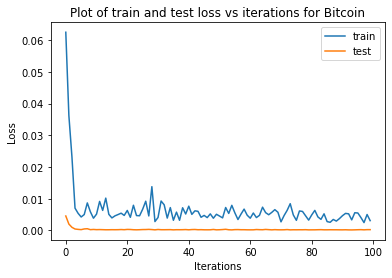

In [21]:
plot_tr_te(iterations,tr,te,'Bitcoin')

In [22]:
train_set, train_label, test_set, test_label, length_test = format_train_test(64,oil_df,0.2,p)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [23]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,p,100)

Iteration 0
********************
The loss for train is:  0.052518054842948914
The loss for test is:  0.004875443235505372
Iteration 1
********************
The loss for train is:  0.03424046188592911
The loss for test is:  0.001901841300423257
Iteration 2
********************
The loss for train is:  0.025891045108437538
The loss for test is:  0.0011593064846238121
Iteration 3
********************
The loss for train is:  0.011755140498280525
The loss for test is:  0.0008394755568588153
Iteration 4
********************
The loss for train is:  0.009782450273633003
The loss for test is:  0.00027128321016789414
Iteration 5
********************
The loss for train is:  0.00851406343281269
The loss for test is:  0.00035228770138928667
Iteration 6
********************
The loss for train is:  0.008394243195652962
The loss for test is:  0.00022592541063204408
Iteration 7
********************
The loss for train is:  0.005201003048568964
The loss for test is:  0.00019263034846517257
Iteration 8
****

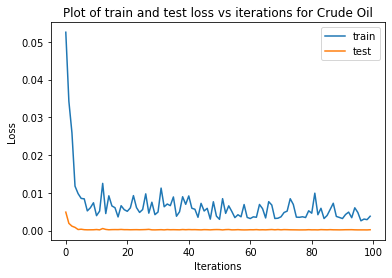

In [24]:
plot_tr_te(iterations,tr,te,'Crude Oil')

In [25]:
train_set, train_label, test_set, test_label,length_test = format_train_test(64,artificial1_df,0.2,p)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [26]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,p,100)

Iteration 0
********************
The loss for train is:  0.005617522168904543
The loss for test is:  0.001827523517931695
Iteration 1
********************
The loss for train is:  0.0035458679776638746
The loss for test is:  0.0011879978319484508
Iteration 2
********************
The loss for train is:  0.002911588177084923
The loss for test is:  0.0010905605258813011
Iteration 3
********************
The loss for train is:  0.002888426184654236
The loss for test is:  0.0010439347051942605
Iteration 4
********************
The loss for train is:  0.0023385551758110523
The loss for test is:  0.0010145978903892683
Iteration 5
********************
The loss for train is:  0.002522905357182026
The loss for test is:  0.001035363469782169
Iteration 6
********************
The loss for train is:  0.0025804315228015184
The loss for test is:  0.0009597190137355938
Iteration 7
********************
The loss for train is:  0.002566341310739517
The loss for test is:  0.000987662826446467
Iteration 8
****

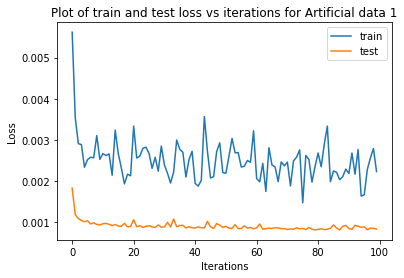

In [27]:
plot_tr_te(iterations,tr,te,'Artificial data 1')

In [28]:
train_set, train_label, test_set, test_label,length_test = format_train_test(64,microsoft_df,0.2,p)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [29]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,p,100)

Iteration 0
********************
The loss for train is:  0.019643152132630348
The loss for test is:  0.01373128779232502
Iteration 1
********************
The loss for train is:  0.0039381226524710655
The loss for test is:  0.0020272475376259536
Iteration 2
********************
The loss for train is:  0.0007008342072367668
The loss for test is:  0.002353361196583137
Iteration 3
********************
The loss for train is:  0.0005162562010809779
The loss for test is:  0.0015756828943267465
Iteration 4
********************
The loss for train is:  0.0003434044192545116
The loss for test is:  0.0012350644828984514
Iteration 5
********************
The loss for train is:  0.00027909953496418893
The loss for test is:  0.001130617645685561
Iteration 6
********************
The loss for train is:  0.0003482661268208176
The loss for test is:  0.0010519886563997716
Iteration 7
********************
The loss for train is:  0.0002976309915538877
The loss for test is:  0.0009727614087751135
Iteration 8


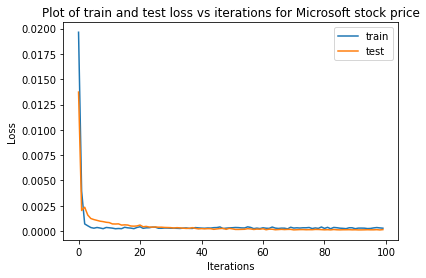

In [30]:
plot_tr_te(iterations,tr,te,'Microsoft stock price')

In [31]:
train_set, train_label, test_set, test_label, length_test = format_train_test(64,sp500_df,0.2,p)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [32]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,p,100)

Iteration 0
********************
The loss for train is:  0.0008980015409179032
The loss for test is:  0.008135037496685982
Iteration 1
********************
The loss for train is:  0.0011508415918797255
The loss for test is:  0.008123500738292933
Iteration 2
********************
The loss for train is:  0.0005038682138547301
The loss for test is:  0.00806528190150857
Iteration 3
********************
The loss for train is:  0.0004734025278594345
The loss for test is:  0.008030240191146731
Iteration 4
********************
The loss for train is:  0.00042355465120635927
The loss for test is:  0.008052654564380646
Iteration 5
********************
The loss for train is:  0.00032733159605413675
The loss for test is:  0.00801247195340693
Iteration 6
********************
The loss for train is:  0.0007347571081481874
The loss for test is:  0.007969086291268468
Iteration 7
********************
The loss for train is:  0.0009877622360363603
The loss for test is:  0.007975380402058363
Iteration 8
****

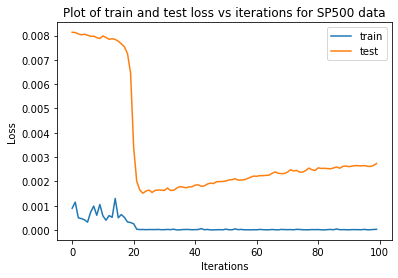

In [33]:
plot_tr_te(iterations,tr,te,'SP500 data')

In [34]:
def plot_test(test_label,predict,test_length,num_predicts):
    a = np.asarray(predict)
    a = np.reshape(a,(-1,1))
    #a = scaler.inverse_transform(a)
    b = np.asarray(test_label)
    #b = scaler.inverse_transform(b)
    b = np.reshape(b,(-1,1))
    #temp = []
    
    print(a.shape)
    print(b.shape)
    #for i in range(0,test_length):
        #temp.append(a[i,num_predicts-5])
    #temp = np.array(temp)
    #temp = np.reshape(temp,(temp.shape[0],1))
    #print(temp.shape)
    plt.plot(a)
    plt.plot(b)

(5760, 1)
(5760, 1)


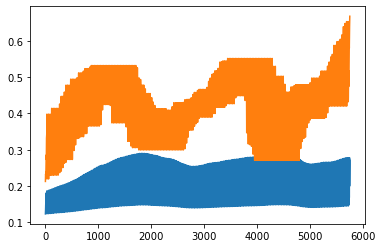

In [35]:
plot_test(test_label,predict,length_test,p)

In [ ]:
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()
criterion3 = nn.NLLLoss()

In [ ]:
#we need to try with three other loss functions as well